In [1]:
import os
from pathlib import Path
import random
import torch
import glob
from shutil import copyfile
import torch.nn as nn
import torchinfo
from torchinfo import summary
import numpy as np

In [2]:
from engine import train
from data_preparation import *
from utils import *
from dataloaders import create_dataloaders
from allResNets import *

In [3]:
change_to_disk()

In [4]:
dataset_path = Path('dataset/')
data_dir = Path("split_1k/")
split_size = [0.8,0.1,0.1]

#split_data(dataset_path, data_dir, split_size, num_img_class=10000)

In [5]:
from torchvision import transforms
#Create transform (in this case for the ResNet images are resized to 224x224 and transformed into Tensors)
data_transform = transforms.Compose([
  # Resize our images to 224x224
  transforms.Resize(size=(224, 224)),
  # Flip the images randomly on the horizontal (just to make it as independent from the position of the pipeline)
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomVerticalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor() 
])

In [6]:
#Paths criados pelo split_data
train_dir = data_dir / Path('train/')
validation_dir = data_dir / Path('validation/')
test_dir = data_dir / Path('test/')

BATCH_SIZE = 32 

train_dataloader, validation_dataloader, test_dataloader, train_data, validation_data, test_data, class_names = create_dataloaders(data_dir,
                                                                                                                                   transform = data_transform,
                                                                                                                                   batch_size = BATCH_SIZE)

In [7]:
# Set number of epochs
NUM_EPOCHS = 5

device = get_device()
model = ResNet18().to(device)

# Setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(params=model.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer() 

# Train model
model_results = train(model=model,
                    train_dataloader=train_dataloader,
                    validation_dataloader=validation_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=NUM_EPOCHS,
                    device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0706 | train_acc: 0.5930 | validation_loss: 0.7762 | validation_acc: 0.7012
Epoch: 2 | train_loss: 0.6716 | train_acc: 0.7705 | validation_loss: 0.5648 | validation_acc: 0.8066
Epoch: 3 | train_loss: 0.5387 | train_acc: 0.8083 | validation_loss: 0.5351 | validation_acc: 0.7773
Epoch: 4 | train_loss: 0.4579 | train_acc: 0.8285 | validation_loss: 0.5050 | validation_acc: 0.7773
Epoch: 5 | train_loss: 0.4154 | train_acc: 0.8440 | validation_loss: 0.3707 | validation_acc: 0.8680
Total training time: 459.656 seconds


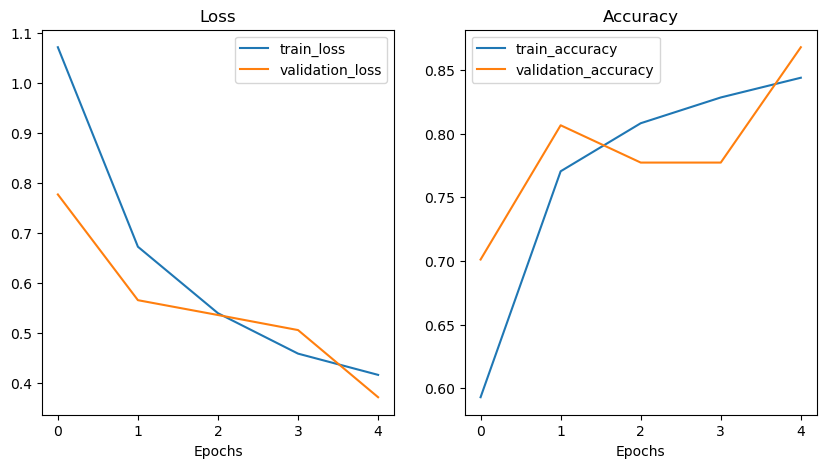

In [8]:
plot_loss_curves(model_results)

<function utils.plot_confusion_matrix(labels, pred_labels, classes)>

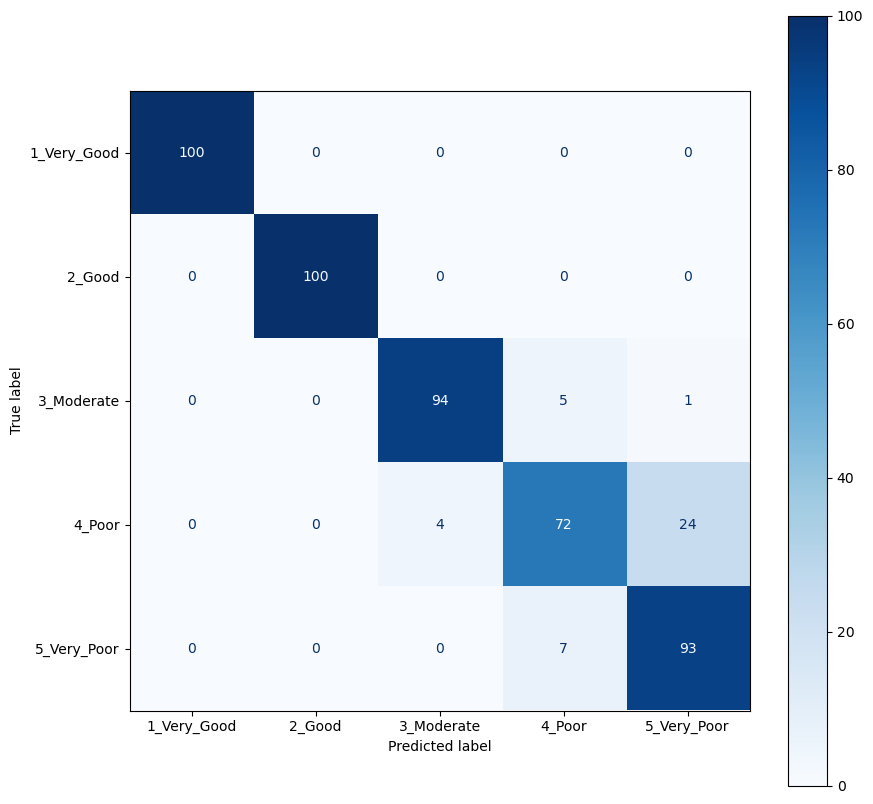

In [9]:
from utils import get_predictions, plot_confusion_matrix

images, labels, probs = get_predictions(model,test_dataloader,device)
pred_labels = torch.argmax(probs, 1) 
plot_confusion_matrix(labels, pred_labels, class_names)

plot_confusion_matrix

In [10]:
models_path = Path('Models/')
model_name = 'ResNet18_1000_class_5_epoch.pth'

save_model(models_path, model_name, model)

model_path = models_path / model_name

loaded_model = ResNet18()
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.to(device)

loaded_model_results = eval_model(  model=loaded_model,
                                    data_loader=validation_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device = device)
loaded_model_results

Saving the model to: Models\ResNet18_1000_class_5_epoch.pth


  0%|          | 0/16 [00:03<?, ?it/s]

{'model_name': 'ResNet',
 'model_loss': 0.36962008476257324,
 'model_acc': 87.1875}

In [11]:
#Measure inference time
dummy_input = torch.rand(32,3,224,224, dtype = torch.float).to(device)
repetitions  = 300

# INIT LOGGERS
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 300
timings=np.zeros((repetitions,1))

#GPU-WARM-UP
for _ in range(10):
    _ = model(dummy_input)

with torch.inference_mode():
    for rep in range(repetitions):
        starter.record()
        _ = model(dummy_input)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn)

28.761896883646646
